# 02901 Advanced Topics in Machine Learning: Graph Representation Learning 

## Day 1 - Shallow Graph Representation Learning 

## Latent Distance Models

## Part 1.

For simplicity, we will concentrate our study on undirected networks. Let $\mathcal{G}=(V,E)$ be a graph where $N := \left| V \right|$ is the number of nodes and $Y_{N \times N}=\left(y_{i,j}\right)\in \{0,1\}^{N\times N}$ be the adjacency matrix of the graph such that $y_{i,j}=1$ if the pair $(i,j) \in E$ otherwise it is equal $0$, for all $ 1\leq i< j\leq N$. We denote the latent representations of nodes by $\mathbf{Z}=(z_{i,d})\in\mathbb{R}^{N\times D}$ where each row vector, $\mathbf{z}_i\in \mathbb{R}^{D}$, indicates the corresponding embedding of node $i \in \mathcal{V}$ in a $D$-dimensional space.


The probability of an edge occurring is considered conditionally independent given the unobserved latent positions. Consequently, the total probability distribution of the network can be written as:
### $ \begin{equation}
    \label{eq:prob_adj}\tag{1}
    P(Y|\mathbf{Z},\mathbf{\theta})=\prod_{i< j}^Np(y_{i,j}|\mathbf{z}_i,\mathbf{z}_j,\mathbf{\theta}_{i,j}),
\end{equation}$
 where $\mathbf{\theta}$ denotes any potential additional parameters, such as covariate regressors.

Let us now define a [Latent Distance Model $(LDM)$](https://www.tandfonline.com/doi/abs/10.1198/016214502388618906) [[1]](#Bibliography) with random effects [[2,3]](#Bibliography) under a [Poisson likelihood](https://en.wikipedia.org/wiki/Poisson_distribution) formulation. We will define a Poisson rate with node-specific biases or random-effects such that the expression for the Poisson rate becomes: 
### $\begin{equation*}
    \lambda_{ij}=\exp\big(\gamma_i+\gamma_j- d(\mathbf{z}_i,\mathbf{z}_j)\big),
    \label{eqn:random_effect}\tag{2}
\end{equation*}$

where $\gamma_i \in \mathbb{R}$ denotes the node-specific random-effects and $d_{ij}(\cdot,\cdot)$ denotes any distance metric obeying the triangle inequality $\big\{ d_{ij}\leq d_{ik}+d_{kj},\:\forall(i,j,k) \in V^3 \big\}$. Considering variables $\{\mathbf{z}_i\}_{i\in V}$ as the latent characteristics, Equation $\eqref{eqn:random_effect}$ shows that similar nodes will be placed closer in the latent space, yielding a high probability of an occurring edge and thus modeling homophily and satisfies network transitivity and reciprocity through the triangle inequality whereas the node specific bias can account for degree heterogeneity.


We are now ready to define the negative log-likelihood of our Poisson $LDM$ which will be our loss function:

### $\begin{equation}
\label{eq:prob_adj}\tag{3}
-\log P(\mathbf{Y}|\Lambda)=-\sum_{\substack{i<j \\ y_{ij}=1}}\log(\lambda_{ij})+\sum_{\substack{i< j }}\Big(\lambda_{ij}+\log(y_{ij!})\Big),
\end{equation}$

where $\mathbf{\Lambda}=(\lambda_{ij})$ is the Poisson rate matrix which has absorbed the dependency over the model parameters.

Let us continue by entering the rate expression in Equation $\eqref{eq:prob_adj}$ while choosing the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) as our metric $d_{ij}(\cdot,\cdot)=||\cdot,\cdot||_2$. This yields:

### $\begin{equation}
\label{eq:nll}\tag{4}
-\log P(\mathbf{Y}|\Lambda)=-\sum_{\substack{i<j \\ y_{ij}=1}}\Big(\gamma_i+\gamma_j-||\mathbf{z}_i -\mathbf{z}_j||_2\Big) + \sum_{i<j}\exp\Big(\gamma_i+\gamma_j-||\mathbf{z}_i -\mathbf{z}_j||_2\Big).
\end{equation}$

## Exercise 1.

In the following blocks you are provided with an $LDM$ object via Pytorch. Your tasks are to:
- Familiriaze yourself with the implementation
- Fill-in the loss function (Equation $\eqref{eq:nll}$) in the missing part of the code
- Train the model
- Perform Link Prediction
- Create network visualizations based on the learned embeddings

In [8]:
# Import all the packages

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(0)

# Visualizations
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import image as mpimg

plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.set_cmap("tab10")

# initialization 
from spectral_clustering import Spectral_clustering_init


# sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_rand_score

# basic
import numpy as np
from tqdm import tqdm


<Figure size 432x288 with 0 Axes>

### Some training details

Initially, we will use some iterations ($500$) of the training procedure to tune only the random effects. This is achieved by training a model with a rate including only the random effects as:

### $\begin{equation*}
    \lambda_{ij}=\exp\big(\gamma_i+\gamma_j\big),
    \label{eqn:random_effect}\tag{5}
\end{equation*}$

and it has been already implemented in the provided code.

Secondly, for a good initialization and faster convergence of the model, the latent variables $\textbf{Z}$ are initialized based on the top $D$ eigenvectors of the network adjacency matrix. This has also been implemented in the code. (Additional initializations are available such as spectral decompositions for different versions of the Normalized Laplacian, as well as, mutlidimensional scaling (MDS)).

You are free to consider advantages and disadvantages of these initialization choices, especially for growing network sizes and ordering of the eigenvalues.

## !!! Please rembember in your implementations, that we will be working with unipartite undirected networks and thus we only consider the upper triangular part of the symmetrix adjacency matrix (i<j) !!!

## !!! For loops are the enemy, please consider vectorization for you implementations !!!

In [9]:
# GPU or CPU environment

CUDA = torch.cuda.is_available()
#CUDA=False
if  CUDA:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = torch.device("cpu")
    torch.set_default_tensor_type('torch.FloatTensor')

In [10]:
class LDM(nn.Module):
    '''
    Latent Distance Model class
    '''
    
    def __init__(self,input_size,latent_dim):
        super(LDM, self).__init__()
        
        # initialization of the class that is responsible for the spectral initialization of the latent variables Z
        # available initialization choices are: 'Adjacency', 'Normalized_sym', 'Normalized', 'MDS'
        # Spectral_clustering_init.__init__(self,num_of_eig=latent_dim,method='Adjacency',device=device)

        # dimensions
        
        self.input_size=input_size
        self.latent_dim=latent_dim
        
        # initially we want to learn the scales of the random effects separately
        self.scaling_RE=True
        
    def read_data(self,path):
        '''
        reads input data:
        
        Netwok Edgelist (upper triangular part of the adjacency matrix for the unipartite undirected network case):

        - edge_pos_i: input data, link row positions i with i<j (edge row position)

        - edge_pos_j: input data, link column positions j with i<j (edge column position)

        '''
        
        # input data, link (edge) rows i positions with i<j
        self.edge_pos_i=torch.from_numpy(np.loadtxt(edge_path+'edge_pos_i.txt')).long().to(device)
        
        # input data, link (edge) column positions with i<j
        self.edge_pos_j=torch.from_numpy(np.loadtxt(edge_path+'edge_pos_j.txt')).long().to(device)
        
       

    def init_parameters(self):
        '''
        define and initialize model parameters
        '''
        
        # Parameters
        
        # Random effects
        self.gamma=nn.Parameter(torch.randn(self.input_size,device=device))
        
        # Latent Variables
        
        # initialize Z based on the leading eigenvectors of the adjacency matrix
        # self.spectral_data=self.spectral_clustering() -> if used with the ASQ, then commented  
        self.latent_z=nn.Parameter(torch.randn(self.input_size,self.latent_dim) )      
        
        
        
    def LDM_Poisson_NLL(self,epoch):
        '''
        Poisson log-likelihood ignoring the log(k!) constant
        
        '''
        self.epoch=epoch
         
        if self.scaling_RE:
            # We will spend 500 iteration on learning the random effects, defining a rate as exp(gamma_i+gamma_j)
            
            mat=torch.exp(self.gamma.unsqueeze(1)+self.gamma) # NxN matrix containing all pairs i,j
            
            # multiply with 0.5 to account for the fact that we caclulated the whole NxN rate matrix
            # subtract the diagonal of the rate matrix since self-links are not allowed
            non_link_nll=0.5*(mat-torch.diag(torch.diagonal(mat))).sum() 
            
            # calculate now the link term of the log-likelihood
            link_nll=(self.gamma[self.edge_pos_i]+self.gamma[self.edge_pos_j]).sum()
            
            # calculate the total nll of the LDM
            loss=-link_nll+non_link_nll
            
            if self.epoch==500:
                # after 500 iteration stop the scaling and switch to full model training
                self.scaling_RE=False
        else:
           
            ####################################################
            ####################################################

            # PLEASE ADD HERE THE LOSS FUNCTION
            # hint: torch.cdist will be usefull

            ####################################################
            ####################################################
            
            mat=torch.exp(-((torch.cdist(self.latent_z,self.latent_z,p=2))+1e-06))
            
            z_pdist1=0.5*torch.mm(torch.exp(self.gamma.unsqueeze(0)),
                                  (torch.mm((mat-torch.diag(torch.diagonal(mat))),
                                            torch.exp(self.gamma).unsqueeze(-1)))
                                 )
            
            z_pdist2=(-((((self.latent_z[self.edge_pos_i]-
                           self.latent_z[self.edge_pos_j]+1e-06)**2).sum(-1)))**0.5+
                      self.gamma[self.edge_pos_i]+self.gamma[self.edge_pos_j]
                     ).sum()
    
            loss=-z_pdist2+z_pdist1
        
        
        return loss
    
        

        

### Network characteristics

Initially, we will work with the [Cora](https://networkrepository.com/cora.php) network which consists of 2708 scientific publications classified into one of seven classes. This citation network consists of 5429 links. The following version contains only 50% of the network edges, the rest have been removed and will be later used for link prediction.


LDM is Running…: 100%|█████████████████| 2000/2000 [01:08<00:00, 29.35it/s]


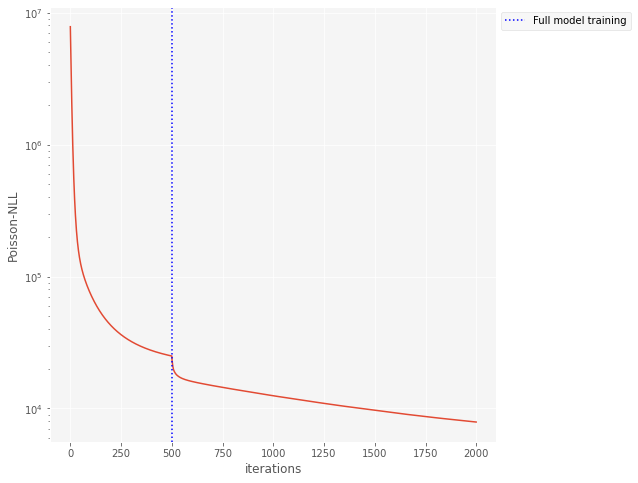

In [11]:
# datase name
dataset='cora'

# latent dimensions of the embeddings Z
latent_dim=2

# path to the folder containing the network edge list
# this version contains only 50% of the network edges, the rest will be used for link prediction
edge_path=f'./networks/{dataset}/'

# path to the folder containing the sampled pairs for link prediction 
# (the 50% hidden edges and the same amount of negative samples)
samples_path=f'./networks/{dataset}/samples_link_prediction/'

def train_model(model,edge_path,epoch_num=2000):
    '''
    Function for training the LDM
    
    ---Arguments---
    model: The LDM object (class)
    edge_path: path containing the edges (str)
    epoch_num: number of training epochs (int)
    '''
    losses=[]

    
    # Read the data
    model.read_data(path=edge_path)
    
    # Define and initialize the model parameters
    model.init_parameters()
    
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.1)  
    
    # training loop
    for epoch in tqdm(range(epoch_num),desc="LDM is Running…",ascii=False, ncols=75):
        
        # calculate the loss function
        loss=model.LDM_Poisson_NLL(epoch=epoch)
        losses.append(loss.item())

        optimizer.zero_grad() # clear the gradients.   
        loss.backward() # backpropagate
        optimizer.step() # update the weights
    
    # Plot the training loss
    plt.figure(figsize=(8,8))
    plt.plot(losses)
    plt.yscale('log')
    plt.xlabel('iterations')
    plt.ylabel('Poisson-NLL')
    plt.axvline(x = 500, color = 'b', label = 'Full model training',ls='dotted')
    plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
    plt.show()

# Size of the network
N_size=int(np.loadtxt(edge_path+'network_size.txt'))

# Define the LDM model
model = LDM(input_size=N_size,latent_dim=latent_dim).to(device)  

# Start the training process
train_model(model=model,edge_path=edge_path)


    
      

## Link prediction

For the link prediction experiments, we follow the well-established strategy \cite{deepwalk-perozzi14, node2vec-kdd16} and we removed $50\%$ of the network edges while keeping the residual network connected. 

The removed edges combined with a sample of the same number of node pairs (which are not the edges of the original network) construct the negative instances for the testing set. 

We utilized the residual network to learn the node embeddings. 

Since we optimize over the likelihood of the network, the $LDM$ can make predictions directly based on the learned Poisson rates (or log-rates) of the test pairs $\{i,j\}$ which utilize the Euclidean norm as $\lambda_{ij}=\exp(\gamma_i+\gamma_j-||z_i-z_j||_2)$.

The Poisson rates essentially define probability propensities over the network dyads. 

It is trivial to show that if:
 

### $\lambda_{ij}(\mathbf{z}_i,\mathbf{z}_j,\gamma_i,\gamma_j)\geq\lambda_{qk}(\mathbf{z}_q,\mathbf{z}_k,\gamma_q,\gamma_k)\; \; \text{ then: }\; \; p(y_{ij}=1|\mathbf{z}_i,\mathbf{z}_j,\gamma_i,\gamma_j)\geq p(y_{q,k}=1|\mathbf{z}_q,\mathbf{z}_k,\gamma_q,\gamma_k)$


Link prediction is a highly imbalanced classification problem so we will use the Area-Under-Curve (AUC) scores for the [Receiver Operating Characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and [Precision-Recall (PR)](https://en.wikipedia.org/wiki/Precision_and_recall) curves.

Most Graph Representation Learning ($GRL$) studies focus on the AUC-ROC scores, do you agree with this choice? If you  had to pick only one metric from the two which one would you use, and why? (hint: you can think about the role of True Negatives in these two metrics)

In [14]:
def link_prediction(model,samples_path):
    
    # file denoting rows i of hidden links and negative samples, with i<j
    total_samples_i=torch.from_numpy(np.loadtxt(samples_path+'total_samples_i.txt')).long().to(device)
    
    # file denoting columns j of hidden links and negative samples, with i<j
    total_samples_j=torch.from_numpy(np.loadtxt(samples_path+'total_samples_j.txt')).long().to(device)
    
    # target vector having 0 if the missing pair is a negative sample and 1 if the pair considers a hidden (removed) edge
    target=torch.from_numpy(np.loadtxt(samples_path+'target.txt')).long().to(device)


    
    with torch.no_grad():
        
        ####################################################
        ####################################################

        # PLEASE ADD HERE THE RATE FOR THE AUC CALCULATIONS

        ####################################################
        ####################################################
        
        z_pdist_miss=(((model.latent_z[total_samples_i]-model.latent_z[total_samples_j])**2).sum(-1))**0.5
        logit_u_miss=-z_pdist_miss+model.gamma[total_samples_i]+model.gamma[total_samples_j]
        rates=logit_u_miss

        # calculate AUC-PR
        precision, recall, thresholds = metrics.precision_recall_curve(target.cpu().data.numpy(), rates.cpu().data.numpy())
        auc_pr=metrics.auc(recall,precision)
        
        # calculate AUC-ROC

        auc_roc=metrics.roc_auc_score(target.cpu().data.numpy(),rates.cpu().data.numpy())
        fpr, tpr, thresholds = metrics.roc_curve(target.cpu().data.numpy(), rates.cpu().data.numpy())
        
        
        
    return auc_roc,fpr, tpr,auc_pr,precision, recall


In [15]:
def plot_auc(auc_roc,fpr, tpr,auc_pr,precision,recall):
     # plot AUC for ROC AND PR curves
        fig = px.area(
            x=recall, y=precision,
            title=f'Cora --- Precision-Recall Curve (AUC={auc_pr:.4f})',
            labels=dict(x='Recall', y='Precision'),
            width=700, height=500
        )
        fig.add_shape(
            type='line', line=dict(dash='dash'),
            x0=0, x1=1, y0=1, y1=0
        )
        fig.update_yaxes(scaleanchor="x", scaleratio=1)
        fig.update_xaxes(constrain='domain')

        fig.show()

        
        #  plot AUC for ROC curve
        fig = px.area(
            x=fpr, y=tpr,
            title=f'Cora --- ROC Curve (AUC={auc_roc:.4f})',
            labels=dict(x='False Positive Rate', y='True Positive Rate'),
            width=700, height=500
        )
        fig.add_shape(
            type='line', line=dict(dash='dash'),
            x0=0, x1=1, y0=0, y1=1
        )

        fig.update_yaxes(scaleanchor="x", scaleratio=1)
        fig.update_xaxes(constrain='domain')
        fig.show()

In [16]:
# perfom link prediction and return auc-roc, auc-pr
auc_roc,fpr, tpr,auc_pr,precision,recall=link_prediction(model=model,samples_path=samples_path) 

# plot curves
plot_auc(auc_roc,fpr, tpr,auc_pr,precision,recall)

### Comparison with baselines

If you want you can compare the performance of $LDM$ against other $GRL$ methods. (The networkx package [KarateClub](https://karateclub.readthedocs.io/en/latest/modules/root.html#) offers multiple baselines and it is easy to use it)

You will then witness that the $LDM$, especially for low-dimensions (D<8), significantly outperforms the state-of-the-art.

As an example, a 2-D [Node2vec](https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf) returns AUC-ROC=0.640 while [NetMF](https://keg.cs.tsinghua.edu.cn/jietang/publications/WSDM18-Qiu-et-al-NetMF-network-embedding.pdf) gives AUC-ROC=0.629.

Lastly, most $GRL$ methods provide somewhat abstract embedding spaces and feature vectors for dyads need to be constructed based on binary operators (average, Hadamard, weighted-L1, weighted-L2). These feature vectors are then used for downstream tasks (such as link prediction) and usually need to be chosen as a post-processing step, greatly affecting performance.



## Embeddings visualization

We will now consider the full Cora network (without missing links) and visualize the learned $2$-dimensional embeddings.

LDM is Running…: 100%|█████████████████| 2000/2000 [01:10<00:00, 28.45it/s]


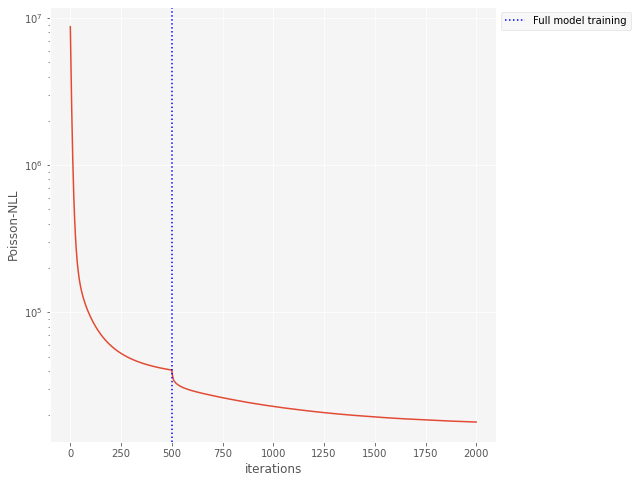

In [17]:
dataset='cora_with_labels'
latent_dim=2

edge_path=f'./networks/{dataset}/'



N_size=int(np.loadtxt(edge_path+'network_size.txt'))

model = LDM(input_size=N_size,latent_dim=latent_dim).to(device)         
train_model(model=model,edge_path=edge_path)



In [18]:
# Read the node labels
labels=np.loadtxt(edge_path+"labels.txt")[:,1]

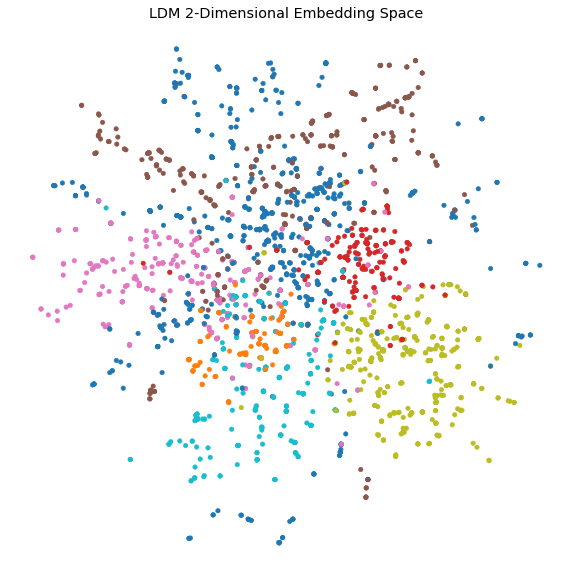

In [20]:
plt.figure(figsize=(10,10))
plt.title('LDM 2-Dimensional Embedding Space')
plt.xlabel('Z1')
plt.ylabel('Z2')
plt.grid(False)
plt.axis('off')
plt.scatter(model.latent_z[:,0].detach().cpu().numpy(),model.latent_z[:,1].detach().cpu().numpy(),c=labels,s=20)
plt.show()

## Comparison with Node2vec

Learning in ultra low-dimensions facilitates direct visualizations of the embedding space, yielding informative node representations and most importantly spaces directly interpretable by human congnition.

State-of-the-art $GRL$ methods learn on much higher dimensions and visualizations rely on post-processing dimensionality reduction methods.

Here, we provide the learned emdedding space of Node2Vec for a 2-dimensional embedding, as well as, a 128-dimensional embedding projected to 2-dimensions via the use of [t-distributed stochastic neighbor embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (TSNE).

You should now compare these three embedding spaces and draw your conclusions :)


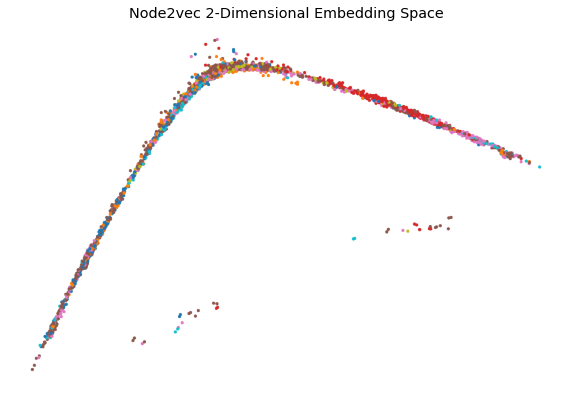

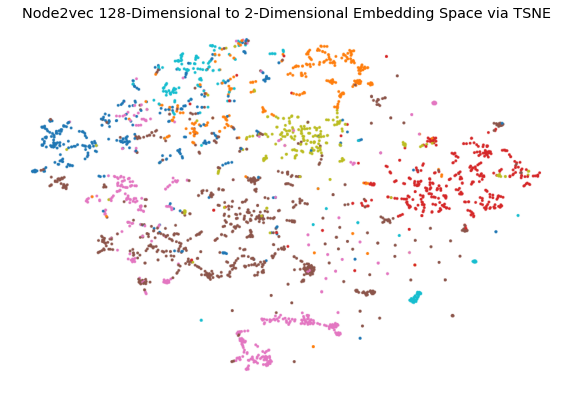

In [21]:
image1 = mpimg.imread("./images/cora_node2vec_d=2.png")
image2 = mpimg.imread("./images/cora_node2vec_d=128_tsne.png")

plt.figure(figsize=(10,10))
plt.title('Node2vec 2-Dimensional Embedding Space')
plt.imshow(image1)
plt.xlabel('Z1')
plt.ylabel('Z2')
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
plt.title('Node2vec 128-Dimensional to 2-Dimensional Embedding Space via TSNE')
plt.imshow(image2)
plt.xlabel('Z1')
plt.ylabel('Z2')
plt.axis('off')
plt.show()

### Extra tasks

The classical $LDM$. as proposed by Peter Hoff did not include random effects but a global bias, with a rate as:

### $\begin{equation*}
    \lambda_{ij}=\exp\big(\beta- d(\mathbf{z}_i,\mathbf{z}_j)\big),
    \label{eqn:random_effect}
\end{equation*}$

with global bias $\beta\in\mathbb{R}$. You can formulate the classical global-bias version of the $LDM$ and compare it with the random effects formulation. You can investigate the different latent spaces, as well as, link prediction and draw conclusions on how we benefit when accounting for degree heterogeneity.


# Part 2

## Hybrid Membership-Latent Distance Model (HM-LDM)

### Preliminaries

Please take some time to familiriaze yourself further with the following preliminaries (if necessary).

- [Non-Negative Matrix Factorization](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization)
- [Simplexes](https://en.wikipedia.org/wiki/Simplex)
- [Identifiability](https://en.wikipedia.org/wiki/Identifiability)


Our next task, will be to learn identifiable $LDM$ representations, $\mathbf{w}_i \in \mathbb{R}^{D}$, for each node $i \in \mathcal{V}$ in a lower dimensional space ($D \ll N$) such that the embeddings also convey information about latent community memberships. This will yield the [Hybrid Membership-Latent Distance Model (HM-LDM)](https://arxiv.org/abs/2206.03463) [[4]](#Bibliography) framework.

For that, we will concentrate on mapping the nodes into the unit $D$-simplex set, $\Delta^{D} \subset \mathbb{R}_{+}^{D+1}$. Therefore, the extracted node embeddings (if identifiable) can convey information about (latent) community memberships. 

Most $GRL$ approaches do not provide identifiable or unique solution guarantees, so their interpretation highly depends on the initialization of the hyper-parameters. In this exercise, we will also address the identifiability problem and seek identifiable solutions which can only be achieved up to a permutation invariance. Lastly, we will also connect the $LDM$ with the Non-Negative Matrix Factorization (NMF) theory.

###  Example:

A latent space in a 2-Simplex with $\mathbf{w}_i \in \mathbb{R}^{3}$ and $\sum_{d=1}^{3} w_{id}=\delta $ with  $\delta \in \mathbb{R}_+$. The node represenations $\mathbf{w}_i$ are constrained to the simplex denoted with the green color.

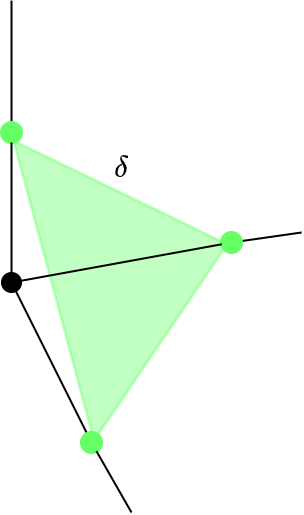



Let us now, define identifiability for a solution, or else for the obtained graph embedding matirx $W$.

### Definition 1.

$\textbf{Identifiabilty}:$ An embedding matrix $\mathbf{W}$ whose rows indicating the corresponding node representations is called an $\textit{identifiable solution up to a permutation}$ if it holds $\widetilde{\mathbf{W}}=\mathbf{W}\mathbf{P}$ for a permutation $\mathbf{P}$ and a solution $\widetilde{\mathbf{W}} \not= \mathbf{W}$.


We continue by defining a simplex-constrained $LDM$ with a log-rate based on different powers of the $\ell^2$-norm as:

  \begin{equation}
     \label{eq:nmf_rate}\tag{6}
     \log \lambda_{ij}=\Big(\gamma_i+\gamma_j-\delta^p\cdot||\mathbf{w}_i -\mathbf{w}_j||_2^p\Big),
 \end{equation}
 where $\mathbf{w_i} \in [0,1]^{D+1}$ and $\sum_{d=1}^{D+1} w_{id}=1$, $\delta \in \mathbb{R}_+$ and $\gamma_i \in \mathbb{R}$ denotes the node-specific random-effects, again describing the tendency of nodes to sending and receiving connections, accounting for degree heterogeneity. In addition, the norm degree $p \in \{1,2\}$ controls the power of the $\ell^2$-norm and combined with the latent embeddings sum-to-one condition constrains the latent space to the $D-$simplex with size equal to $\delta$.

Finally, it is time to explain our motivation for constraining the LDM on the $D$-simplex, as well as, how the identifiability can be achieved in such a latent space. For simplicity and visualization purposes, we will consider again the $2$-simplex example:

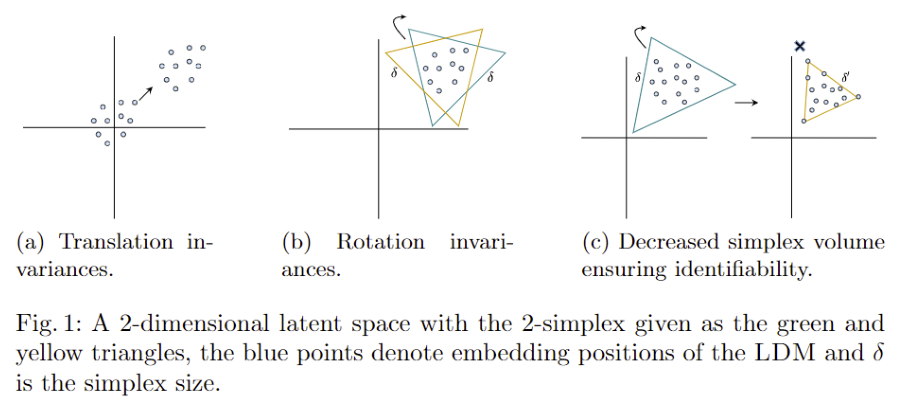

In [22]:
image3 = mpimg.imread("./images/hmldm.PNG")

plt.figure(figsize=(16,16))
plt.imshow(image3)
plt.xlabel('Z1')
plt.ylabel('Z2')
plt.axis('off')
plt.show()


In Fig. 1, the embedding vectors, $\{\mathbf{w}_i\}_{i=1}^{N}$, are constrained to non-negative values and to sum to one. Thereby, they reside on a simplex showing the participation of node $i\in\mathcal{V}$ over $D+1$ latent communities. 

Any $LDM$ can be translated to the non-negative orthant without any loss in performance or in expressive capability. Non-negative embeddings do not affect the distance metric, as it is invariant to translation, as shown by Fig. 1 (a). 

In addition, the $D$-dimensional non-negative orthant can be reconstructed by a large enough $D$-simplex. Based on these arguments, it is trivial to show that for large values of the $\delta$ parameter in Eq. (6), despite the sum-to-one constraint on the embeddings $\mathbf{W}$, we obtain an unconstrained $LDM$, as distances are unbounded when $\delta\rightarrow+\infty$. In this case, the memberships defined by $\mathbf{W}$ are not uniquely identifiable due to the distance invariance of rotation, as seen in Fig. 1 (b).  

However, by shrinking the volume of the simplex (equivalent to decreasing $\delta$), eventually the $D$-dimensional space of $LDM$ will no longer be enclosed inside the $D$-simplex, forcing nodes to start populating the corners of this smaller simplex. We call a node $\textit{champion}$ (formal definition follows) if its latent representation is a standard binary unit vector. 

### Definition 2.

$\textbf{Community champion}$: A node for a latent community is called $\textit{champion}$ if it belongs to the community (simplex corner) while forming a binary unit vector.


The champion nodes are of great significance for identifiability because if every corner of the simplex is populated by at least one node (champion), then the solution of the model is identifiable (up to a permutation matrix) (Def. 1) as any random rotation does not leave the solution invariant anymore, as shown by Fig. 1 (c). 

We observe then, that the scalar, $\delta$, controls the type of memberships of the model and its expressive capabilities. Large enough values lead to the basic $LDM$ but inherits its rotational invariance. Small values of $\delta$ lead to identifiable solutions and ultimately hard cluster assignments. Thereby, for very small values of $\delta$, nodes are solely assigned to the simplex corners. Lastly, we can also find regimes of values for $\delta$ that offer identifiable solutions but also performance similar to $LDM$, defining a silver lining.

## NMF relation for p=2

A different take on the identifiability of the model for $p=2$, can also be given under the Non-negative Matrix Factorization (NMF) theory. This is easily shown by a re-parameterization of Eq. (6) by $\tilde{\gamma}_i+\tilde{\gamma}_j+2\delta^2\cdot(\mathbf{w}_i\mathbf{w}_j^{\top})$. In this formulation, the product $\mathbf{W}\mathbf{W}^{\top}$ defines a symmetric NMF problem which is an identifiable and unique factorization (up to permutation invariance) when $\mathbf{W}$ is full-rank and at least one node resides solely in each simplex corner, ensuring separability [[5,6]](#Bibliography).

## Exercise 2.

In the following blocks you are provided with an $HM-LDM$ object via Pytorch. Your task will be again to:
- Familiriaze yourself with the implementation
- Derive and fill-in the loss function in the missing part of the code for only for $p=1$
- Train the model
- Perform Link Prediction for different values of $\delta$
- Perform and validate community detection for different values of $\delta$



In [26]:
class HMLDM(nn.Module,Spectral_clustering_init):
    '''
    Hybrid Membership-Latent Distance Model class
    '''
    
    def __init__(self,input_size,latent_dim,delta=1):
        super(HMLDM, self).__init__()
        
        # initialization of the class that is responsible for the spectral initialization of the latent variables Z
        # available initialization choices are: 'Adjacency', 'Normalized_sym', 'Normalized', 'MDS'
        Spectral_clustering_init.__init__(self,num_of_eig=latent_dim,method='Adjacency',device=device)

        # dimensions
        
        self.input_size=input_size
        self.latent_dim=latent_dim
        
        # initially we want to learn the scales of the random effects separately
        self.scaling_RE=True
        
        # hyperparameter controlling the simplex volume
        self.delta=delta
        
        
    def read_data(self,path):
        '''
        reads input data:
        
        Netwok Edgelist (upper triangular part of the adjacency matrix for the unipartite undirected network case):

        - edge_pos_i: input data, link row positions i with i<j (edge row position)

        - edge_pos_j: input data, link column positions j with i<j (edge column position)

        '''
        
        # input data, link (edge) rows i positions with i<j
        self.edge_pos_i=torch.from_numpy(np.loadtxt(edge_path+'edge_pos_i.txt')).long().to(device)
        np.savetxt(edge_path+'edge_pos_i.txt',np.loadtxt(edge_path+'edge_pos_i.txt'),fmt='%s')
        
        # input data, link (edge) column positions with i<j
        self.edge_pos_j=torch.from_numpy(np.loadtxt(edge_path+'edge_pos_j.txt')).long().to(device)
        np.savetxt(edge_path+'edge_pos_j.txt',np.loadtxt(edge_path+'edge_pos_j.txt'),fmt='%s')

       

    def init_parameters(self):
        '''
        define and initialize model parameters
        '''
        
        self.Softmax=nn.Softmax(1)

        
        # Parameters
        
        # Random effects
        self.gamma=nn.Parameter(torch.randn(self.input_size,device=device))
        
        # Latent Variables
        
        # initialize Z based on the leading eigenvectors of the adjacency matrix
        self.spectral_data=self.spectral_clustering()
        self.latent_w1=nn.Parameter(self.spectral_data)       
        
        
        
    def LDM_Poisson_NLL(self,epoch):
        '''
        Poisson log-likelihood ignoring the log(k!) constant
        
        '''
        self.epoch=epoch
         
        if self.scaling_RE:
            # We will spend 500 iteration on learning the random effects, defining a rate as exp(gamma_i+gamma_j)
            
            mat=torch.exp(self.gamma.unsqueeze(1)+self.gamma) # NxN matrix containing all pairs i,j
            
            # multiply with 0.5 to account for the fact that we caclulated the whole NxN rate matrix
            # subtract the diagonal of the rate matrix since self-links are not allowed
            non_link_nll=0.5*(mat-torch.diag(torch.diagonal(mat))).sum() 
            
            # calculate now the link term of the log-likelihood
            link_nll=(self.gamma[self.edge_pos_i]+self.gamma[self.edge_pos_j]).sum()
            
            # calculate the total nll of the LDM
            loss=-link_nll+non_link_nll
            
            if self.epoch==500:
                # after 500 iteration stop the scaling and switch to full model training
                self.scaling_RE=False
        else:
            
            # here we provide you with the constrained embeddings on the standard simplex
            self.latent_w=self.Softmax(self.latent_w1)

           
            ####################################################
            ####################################################

            # PLEASE ADD HERE THE LOSS FUNCTION
            
            # you can access the delta parameter as self.delta

            ####################################################
            ####################################################
           
            loss=...
        
        
        return loss
    

Initially, we will use a General Relativity and Quantum Cosmology arxiv collaboration network. Again for link prediction purposes we have removed $50\%$ of the network edges which later we will try and predict.

To test how the $\delta$ parameter controls the expressive capabilities of the $HM-LDM$ we will use on big and one smaller value, $\delta=100$ and $\delta=1$, respectively.


Let us start now by training an $HM-LDM$ with $p=1$ and $\delta=100$.

LDM is Running…: 100%|█████████████████| 2000/2000 [01:20<00:00, 24.93it/s]


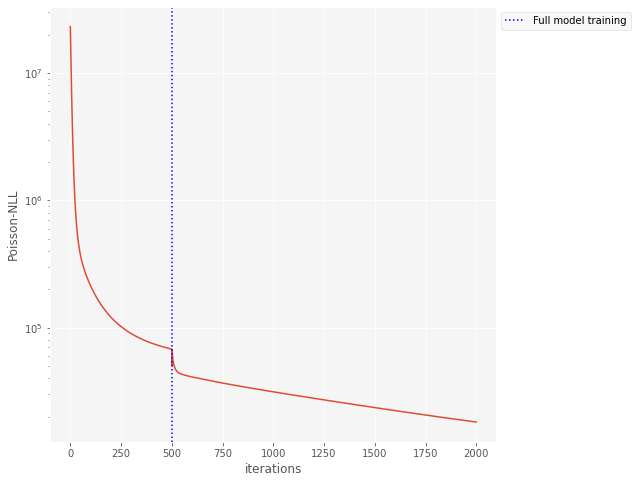

In [27]:
# datase name
dataset='grqc'

# latent dimensions of the embeddings W
latent_dim=8

# path to the folder containing the network edge list
# this version contains only 50% of the network edges, the rest will be used for link prediction
edge_path=f'./networks/{dataset}/'

# path to the folder containing the sampled pairs for link prediction 
# (the 50% hidden edges and the same amount of negative samples)
samples_path=f'./networks/{dataset}/samples_link_prediction/'


# Size of the network
N_size=int(np.loadtxt(edge_path+'network_size.txt'))

# Define the LDM model
model = HMLDM(input_size=N_size,latent_dim=latent_dim,delta=100).to(device)  

# Start the training process
train_model(model=model,edge_path=edge_path)


In [28]:
def link_prediction_hm(model,samples_path):
    
    # file denoting rows i of hidden links and negative samples, with i<j
    total_samples_i=torch.from_numpy(np.loadtxt(samples_path+'total_samples_i.txt')).long().to(device)
    
    # file denoting columns j of hidden links and negative samples, with i<j
    total_samples_j=torch.from_numpy(np.loadtxt(samples_path+'total_samples_j.txt')).long().to(device)
    
    # target vector having 0 if the missing pair is a negative sample and 1 if the pair considers a hidden (removed) edge
    target=torch.from_numpy(np.loadtxt(samples_path+'target.txt')).long().to(device)


    
    with torch.no_grad():
        
        ####################################################
        ####################################################

        # PLEASE ADD HERE THE RATE FOR THE AUC CALCULATIONS

        ####################################################
        ####################################################
        
       
        rates=...

        # calculate AUC-PR
        precision, recall, thresholds = metrics.precision_recall_curve(target.cpu().data.numpy(), rates.cpu().data.numpy())
        auc_pr=metrics.auc(recall,precision)
        
        # calculate AUC-ROC

        auc_roc=metrics.roc_auc_score(target.cpu().data.numpy(),rates.cpu().data.numpy())
        fpr, tpr, thresholds = metrics.roc_curve(target.cpu().data.numpy(), rates.cpu().data.numpy())
        
        
        
    return auc_roc,fpr, tpr,auc_pr,precision, recall


## Link prediction

In [29]:
# perfom link prediction and return auc-roc, auc-pr
auc_roc,fpr, tpr,auc_pr,precision,recall=link_prediction_hm(model=model,samples_path=samples_path) 

# plot curves
plot_auc(auc_roc,fpr, tpr,auc_pr,precision,recall)

If you want you can verufy the classical $LDM$ returns similar results to $HM-LDM$ for $p=1$ and $\delta=100$. 

Now, we will constrain the model to the standard simplex by setting $\delta=1$.

LDM is Running…: 100%|█████████████████| 2000/2000 [01:18<00:00, 25.44it/s]


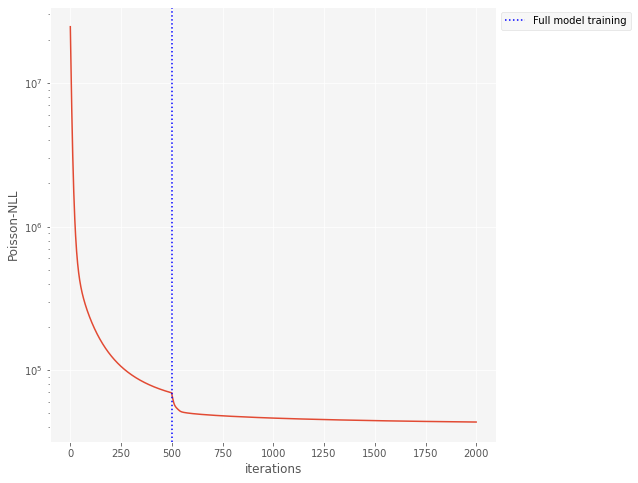

In [30]:
# Define the LDM model
model = HMLDM(input_size=N_size,latent_dim=latent_dim,delta=1).to(device)  

# Start the training process
train_model(model=model,edge_path=edge_path)


In [31]:
# perfom link prediction and return auc-roc, auc-pr
auc_roc,fpr, tpr,auc_pr,precision,recall=link_prediction_hm(model=model,samples_path=samples_path) 

# plot curves
plot_auc(auc_roc,fpr, tpr,auc_pr,precision,recall)

You can witness how this smaller simplex volume decreases the model's expressive capabilities and thus performance.

## Re-Ordering of the adjacency matrix based on inferred memberships

You will now plot the initial adjacency matrix, as well as, the re-ordered adjacency matrix based on the inferred $HM-LDM$ memberships.

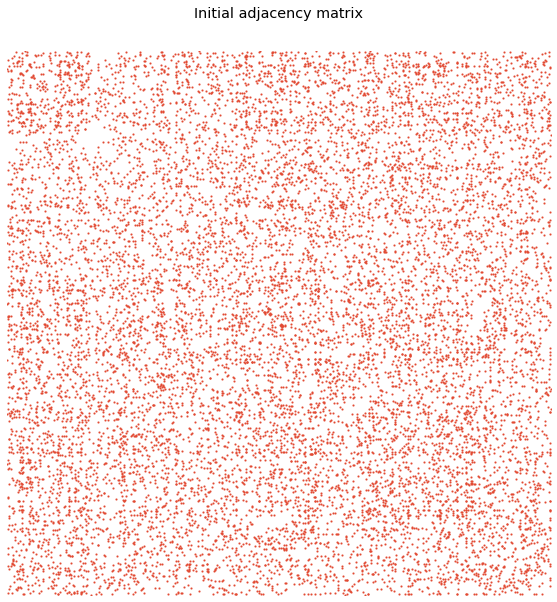

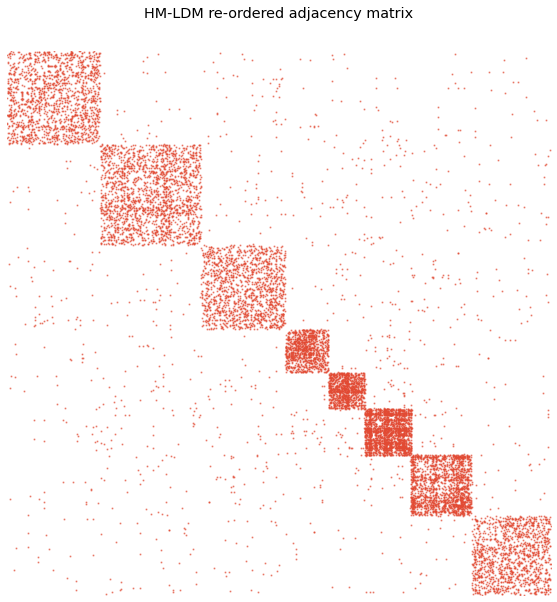

In [32]:
from scipy.sparse import coo_matrix,csr_matrix
plt.rcParams["figure.figsize"] = (10,10)

w_idx=model.latent_w.argmax(1)

f_z=w_idx.argsort()

new_i=torch.cat((model.edge_pos_i,model.edge_pos_j))
new_j=torch.cat((model.edge_pos_j,model.edge_pos_i))

D=csr_matrix((np.ones(new_i.shape[0]),(new_i.cpu().numpy(),new_j.cpu().numpy())),shape=(model.input_size,model.input_size))

plt.title('Initial adjacency matrix')
plt.spy(D,markersize=1,alpha=1)
plt.axis('off')
plt.show()

# order the adj matrix based on the community allocations
D = D[:, f_z.cpu().numpy()][f_z.cpu().numpy()]

plt.title('HM-LDM re-ordered adjacency matrix')
plt.spy(D,markersize=1,alpha=0.5)
plt.axis('off')
plt.show()

## Community detection

We will now use, the Amherst network, a university Facebook social network which defines ground-truth community labels.

We will perform community detection based on the obtained memberships $W$ of the $HM-LDM$ $(p=1)$ for $\delta=100$ and $\delta=1$.

We start again with an $HM-LDM$ having a large volume by setting $\delta=100$. In general, this choice of $\delta$ yields soft clustering assignments and mixed-memberships.

LDM is Running…: 100%|█████████████████| 2000/2000 [01:17<00:00, 25.69it/s]


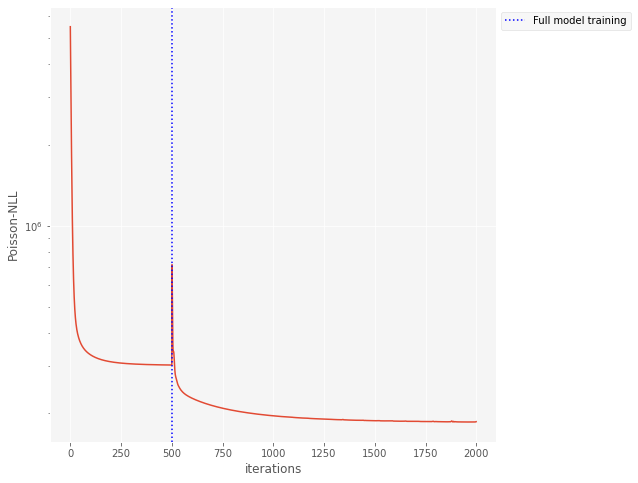

In [33]:
# datase name
dataset='amherst'

# path to the folder containing the network edge list
# this version contains only 50% of the network edges, the rest will be used for link prediction
edge_path=f'./networks/{dataset}/'

# latent dimensions of the embeddings W
# They are set to the number of ground-truth communities so we extract memberships over them.
labels=torch.from_numpy(np.loadtxt(edge_path+'labels.txt')).long().to(device)
latent_dim=int(labels[:,1].max()+1)



# path to the folder containing the sampled pairs for link prediction 
# (the 50% hidden edges and the same amount of negative samples)
samples_path=f'./networks/{dataset}/samples_link_prediction/'


# Size of the network
N_size=int(np.loadtxt(edge_path+'network_size.txt'))


# Set delta value
delta=100

# Define the LDM model
model = HMLDM(input_size=N_size,latent_dim=latent_dim,delta=delta).to(device)  

# Start the training process
train_model(model=model,edge_path=edge_path)

### For the community detection evaluation we will calculate the [normalized mutual information](https://en.wikipedia.org/wiki/Mutual_information#Normalized_variants) (NMI) and the [adjusted rand index](https://en.wikipedia.org/wiki/Rand_index#Adjusted_Rand_index) (ARI) scores.

#### You need to calculate the community allocated label for each node. Remember that each embedding $w_i$ conveys information about community memberships. How should you decide on the community labels for the nodes?

In [34]:
# Calculate community allocation
# memberiships should be converted from torch tensors to numpy arrays or python lists
memberships=...


# NMI calculation
nmi=normalized_mutual_info_score(labels[:,1].cpu().numpy(),memberships)
                        
# ARI calculation
ari=adjusted_rand_score(labels[:,1].cpu().numpy(),memberships)

print(f'Normalized mutual information score for delta={delta} is NMI={nmi:.4f}')
print(f'Adjusted rand index score for delta={delta} is ARI={ari:.4f}')

Normalized mutual information score for delta=100 is NMI=0.3386
Adjusted rand index score for delta=100 is ARI=0.1867


We continue by again constraing the $HM-LDM$ to a smaller volume by setting $\delta=1$. In general, this choice of $\delta$ yields hard clustering assignments.

LDM is Running…: 100%|█████████████████| 2000/2000 [01:21<00:00, 24.64it/s]


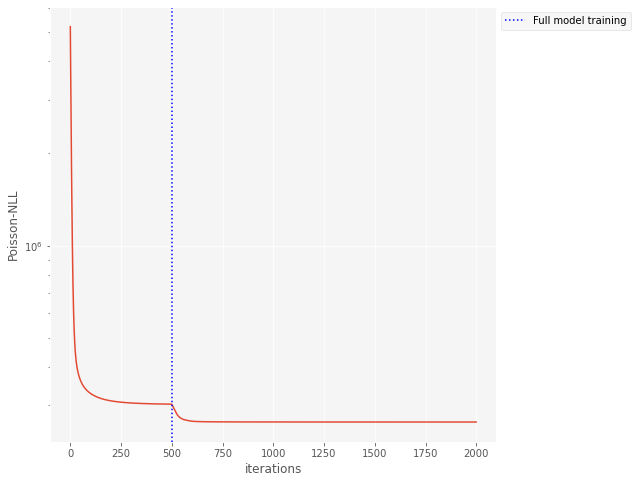

In [35]:
# Set delta value
delta=1

# Define the LDM model
model = HMLDM(input_size=N_size,latent_dim=latent_dim,delta=delta).to(device)  

# Start the training process
train_model(model=model,edge_path=edge_path)

In [36]:
# Calculate community allocation
# memberiships should be converted from torch tensors to numpy arrays or python lists
memberships=...


# NMI calculation
nmi=normalized_mutual_info_score(labels[:,1].cpu().numpy(),memberships)
                        
# ARI calculation
ari=adjusted_rand_score(labels[:,1].cpu().numpy(),memberships)

print(f'Normalized mutual information score for delta={delta} is NMI={nmi:.4f}')
print(f'Adjusted rand index score for delta={delta} is ARI={ari:.4f}')

Normalized mutual information score for delta=1 is NMI=0.6061
Adjusted rand index score for delta=1 is ARI=0.5252


You are now able to compare the community detection scores and how identifiability affects differently various $GRL$ downstream tasks. In general, we saw that high simplex volumes provide an unconstrained $LDM$ while smaller simplex volumes constrain the $LDM$ but provide informative and identifiable embeddings.

Can you name the trade-offs between large and small volumes of the simplex?

There exist a silver lining for the choice of the constructed simplex volumes, where we can obtain link prediction performance equivalent to the powerfull $LDM$ while also having informative embeddings with either hard assignments or mixed-memberships.

### Extra task:

If we want to generalize the $HM-LDM$ model to the analysis of the bipartite networks what should we modify?

In that case, and for $p=2$, how does the symmetric NMF formulation changes? 

Do we still have the same requirements for identifiable embeddings?

Try and implement a bipartite network version of $HM-LDM$ and perform the same (or new) experiments :)

# Bibliography

[1] Peter D Hoff, Adrian E Raftery & Mark S Handcock (2002) Latent Space Approaches to Social Network Analysis, Journal of the American Statistical Association, 97:460, 1090-1098, DOI: 10.1198/016214502388618906

[2] Peter D Hoff (2005) Bilinear Mixed-Effects Models for Dyadic Data, Journal of the American Statistical Association, 100:469, 286-295, DOI: 10.1198/016214504000001015

[3] Krivitsky PN, Handcock MS, Raftery AE, Hoff PD. Representing Degree Distributions, Clustering, and Homophily in Social Networks With Latent Cluster Random Effects Models. Soc Networks. 2009 Jul 1;31(3):204-213. doi: 10.1016/j.socnet.2009.04.001. PMID: 20191087; PMCID: PMC2827882.

[4] Nikolaos Nakis, Abdulkadir Çelikkanat, Morten Mørup (2022) HM-LDM: A Hybrid-Membership Latent Distance Model, 11th International Conference on Complex Networks and their Applications, CNA 22

[5] Huang, K., Sidiropoulos, N.D., Swami, A.: Non-negative matrix factorization revisited: Uniqueness and algorithm for symmetric decomposition. IEEE Trans. Signal
Process 62(1), 211–224 (2014)

[6] Mao, X., Sarkar, P., Chakrabarti, D.: On mixed memberships and symmetric nonnegative matrix factorizations. In: ICML. vol. 70 (2017)

